In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix

# river incremental learners
from river import tree, naive_bayes, linear_model

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [2]:
# 1_load_data.py - purpose: load dataset and basic inspection
df = pd.read_csv("D:/fraud_det/creditcard.csv")   # place creditcard.csv in same directory
df = df.sort_values('Time').reset_index(drop=True)

print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))
print("Fraud ratio (Class=1):", df['Class'].mean())
print("Time min/max:", df['Time'].min(), df['Time'].max())


Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Fraud ratio (Class=1): 0.001727485630620034
Time min/max: 0.0 172792.0


In [3]:
# 2_features_scaler.py - purpose: select features and initialize scaler
feature_cols = [c for c in df.columns if c not in ['Time', 'Class']]
X_all = df[feature_cols].copy()
y_all = df['Class'].astype(int).values

# convert to numpy for speed in streaming loop
X_np = X_all.values.astype(float)
n_samples = X_np.shape[0]
print("Total samples:", n_samples, "Features:", X_np.shape[1])

# scaler: we'll fit on a small warmup block (ease-of-use). 
# For strict streaming you can switch to incremental scaler later.
initial_warmup = 5000
scaler = StandardScaler()
scaler.fit(X_np[:initial_warmup])


Total samples: 284807 Features: 29


,copy,True
,with_mean,True
,with_std,True


In [4]:
# 3_stream_generator.py - purpose: helper for batch streaming (optional)
def stream_data_batches(X_arr, y_arr, batch_size=5000):
    for i in range(0, X_arr.shape[0], batch_size):
        yield X_arr[i:i+batch_size], y_arr[i:i+batch_size]


In [5]:
# 4_linucb.py - purpose: LinUCB agent implementation
class LinUCB:
    def __init__(self, n_arms, context_dim, alpha=1.0):
        self.n_arms = n_arms
        self.d = context_dim
        self.alpha = alpha
        self.A = [np.eye(self.d) for _ in range(n_arms)]
        self.b = [np.zeros(self.d) for _ in range(n_arms)]

    def select_arm(self, x):
        best_arm = 0
        best_val = -np.inf
        for a in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv.dot(self.b[a])
            est = theta.dot(x)
            conf = self.alpha * math.sqrt(x.dot(A_inv).dot(x))
            val = est + conf
            if val > best_val:
                best_val = val
                best_arm = a
        return best_arm

    def update(self, arm, x, reward):
        x = x.reshape(-1)
        self.A[arm] += np.outer(x, x)
        self.b[arm] += reward * x


In [6]:
# 5_reward.py - purpose: reward for RL update (tuneable)
def compute_reward(true_label, pred_label, reward_tp=5.0, reward_tn=1.0, penalty_fn=-5.0, penalty_fp=-1.0):
    if true_label == 1 and pred_label == 1:
        return reward_tp
    if true_label == 0 and pred_label == 0:
        return reward_tn
    if true_label == 1 and pred_label == 0:
        return penalty_fn
    if true_label == 0 and pred_label == 1:
        return penalty_fp
    return 0.0


In [7]:
# 6_init_models.py - purpose: create arms and LinUCB
context_dim = min(20, X_np.shape[1])   # number of features used as context for LinUCB
alpha = 0.8                            # exploration factor

arms = [
    tree.HoeffdingTreeClassifier(),
    naive_bayes.GaussianNB(),
    linear_model.LogisticRegression()
]
n_arms = len(arms)
linucb = LinUCB(n_arms=n_arms, context_dim=context_dim, alpha=alpha)


In [8]:
# 7_warmup.py - purpose: warm-start the learners
for i in range(initial_warmup):
    x_raw = X_np[i]
    x_scaled = scaler.transform([x_raw])[0]
    y = int(y_all[i])
    feat_dict = {str(j): float(val) for j, val in enumerate(x_scaled)}
    for arm in arms:
        arm.learn_one(feat_dict, y)
print("Warmup complete:", initial_warmup, "samples used")


Warmup complete: 5000 samples used


In [9]:
# 8_streaming_loop.py - purpose: core streaming + RL + online updates
threshold = 0.5         # probability threshold for class=1
eval_interval = 20000   # when to print/save partial metrics (tune)

y_true_list = []
y_pred_list = []
prob_pred_list = []
metrics_records = []
sample_points = []

for i in tqdm(range(initial_warmup, n_samples), desc="Streaming"):
    x_raw = X_np[i]
    x_scaled = scaler.transform([x_raw])[0]
    x_context = x_scaled[:context_dim].reshape(-1)
    y_true = int(y_all[i])

    # LinUCB chooses an arm
    chosen = linucb.select_arm(x_context)

    # Prepare feature dict for river learners
    feat_dict = {str(j): float(val) for j, val in enumerate(x_scaled)}
    arm = arms[chosen]

    # Predict probability for class 1
    try:
        proba = arm.predict_proba_one(feat_dict).get(1, 0.0)
    except Exception:
        p = arm.predict_one(feat_dict)
        proba = float(p)

    y_pred = 1 if proba >= threshold else 0

    # Record
    y_true_list.append(y_true)
    y_pred_list.append(y_pred)
    prob_pred_list.append(proba)

    # Reward and RL update
    reward = compute_reward(y_true, y_pred)
    linucb.update(chosen, x_context, reward)

    # Online update of chosen arm
    arm.learn_one(feat_dict, y_true)

    # Periodic evaluation / logging
    if (i - initial_warmup + 1) % eval_interval == 0 or i == n_samples - 1:
        acc = accuracy_score(y_true_list, y_pred_list)
        prec = precision_score(y_true_list, y_pred_list, zero_division=0)
        rec = recall_score(y_true_list, y_pred_list, zero_division=0)
        f1 = f1_score(y_true_list, y_pred_list, zero_division=0)
        mse = mean_squared_error(y_true_list, prob_pred_list)
        tn, fp, fn, tp = confusion_matrix(y_true_list, y_pred_list).ravel()
        print("\n--- Partial results at sample", i+1, "---")
        print(f"Seen: {len(y_true_list)}  Acc: {acc:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}  MSE: {mse:.6f}")
        print(f"CM: TN={tn} FP={fp} FN={fn} TP={tp}")
        metrics_records.append({
            'samples': len(y_true_list),
            'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'mse': mse,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
        })
        sample_points.append(len(y_true_list))


Streaming:   7%|▋         | 20529/279807 [00:05<01:16, 3371.02it/s]


--- Partial results at sample 25000 ---
Seen: 20000  Acc: 0.9962  Prec: 0.5354  Rec: 0.8000  F1: 0.6415  MSE: 0.003622
CM: TN=19856 FP=59 FN=17 TP=68


Streaming:  14%|█▍        | 40343/279807 [00:10<01:30, 2651.29it/s]


--- Partial results at sample 45000 ---
Seen: 40000  Acc: 0.9954  Prec: 0.4164  Rec: 0.8116  F1: 0.5504  MSE: 0.004347
CM: TN=39705 FP=157 FN=26 TP=112


Streaming:  22%|██▏       | 60458/279807 [00:16<01:10, 3123.47it/s]


--- Partial results at sample 65000 ---
Seen: 60000  Acc: 0.9957  Prec: 0.3722  Rec: 0.7892  F1: 0.5058  MSE: 0.004085
CM: TN=59613 FP=221 FN=35 TP=131


Streaming:  29%|██▊       | 80347/279807 [00:23<02:11, 1520.34it/s]


--- Partial results at sample 85000 ---
Seen: 80000  Acc: 0.9951  Prec: 0.3110  Rec: 0.7861  F1: 0.4457  MSE: 0.004676
CM: TN=79449 FP=350 FN=43 TP=158


Streaming:  36%|███▌      | 100296/279807 [00:32<02:03, 1451.27it/s]


--- Partial results at sample 105000 ---
Seen: 100000  Acc: 0.9949  Prec: 0.2796  Rec: 0.7729  F1: 0.4107  MSE: 0.004793
CM: TN=99315 FP=456 FN=52 TP=177


Streaming:  43%|████▎     | 120529/279807 [00:40<01:18, 2033.97it/s]


--- Partial results at sample 125000 ---
Seen: 120000  Acc: 0.9948  Prec: 0.2582  Rec: 0.7695  F1: 0.3867  MSE: 0.004937
CM: TN=119178 FP=566 FN=59 TP=197


Streaming:  50%|█████     | 140205/279807 [00:48<02:03, 1131.53it/s]


--- Partial results at sample 145000 ---
Seen: 140000  Acc: 0.9948  Prec: 0.2455  Rec: 0.7770  F1: 0.3731  MSE: 0.004881
CM: TN=139058 FP=664 FN=62 TP=216


Streaming:  57%|█████▋    | 160338/279807 [00:54<01:09, 1712.03it/s]


--- Partial results at sample 165000 ---
Seen: 160000  Acc: 0.9952  Prec: 0.2888  Rec: 0.7915  F1: 0.4232  MSE: 0.004513
CM: TN=158953 FP=692 FN=74 TP=281


Streaming:  64%|██████▍   | 180432/279807 [01:01<01:00, 1644.22it/s]


--- Partial results at sample 185000 ---
Seen: 180000  Acc: 0.9952  Prec: 0.2701  Rec: 0.7918  F1: 0.4028  MSE: 0.004499
CM: TN=178854 FP=781 FN=76 TP=289


Streaming:  72%|███████▏  | 200147/279807 [01:09<01:52, 707.07it/s] 


--- Partial results at sample 205000 ---
Seen: 200000  Acc: 0.9952  Prec: 0.2580  Rec: 0.7872  F1: 0.3886  MSE: 0.004578
CM: TN=198727 FP=883 FN=83 TP=307


Streaming:  79%|███████▉  | 220465/279807 [01:17<00:39, 1497.32it/s]


--- Partial results at sample 225000 ---
Seen: 220000  Acc: 0.9951  Prec: 0.2464  Rec: 0.7816  F1: 0.3746  MSE: 0.004628
CM: TN=218603 FP=985 FN=90 TP=322


Streaming:  86%|████████▌ | 240553/279807 [01:23<00:22, 1759.48it/s]


--- Partial results at sample 245000 ---
Seen: 240000  Acc: 0.9950  Prec: 0.2412  Rec: 0.7883  F1: 0.3694  MSE: 0.004711
CM: TN=238455 FP=1101 FN=94 TP=350


Streaming:  93%|█████████▎| 260404/279807 [01:30<00:21, 891.49it/s] 


--- Partial results at sample 265000 ---
Seen: 260000  Acc: 0.9951  Prec: 0.2418  Rec: 0.7862  F1: 0.3698  MSE: 0.004651
CM: TN=258347 FP=1176 FN=102 TP=375


Streaming: 100%|██████████| 279807/279807 [01:39<00:00, 2815.22it/s]


--- Partial results at sample 284807 ---
Seen: 279807  Acc: 0.9951  Prec: 0.2301  Rec: 0.7791  F1: 0.3552  MSE: 0.004668
CM: TN=278043 FP=1275 FN=108 TP=381


In [10]:
# 9_final_metrics.py - purpose: final evaluation and confusion matrix
if len(y_true_list) > 0:
    acc = accuracy_score(y_true_list, y_pred_list)
    prec = precision_score(y_true_list, y_pred_list, zero_division=0)
    rec = recall_score(y_true_list, y_pred_list, zero_division=0)
    f1 = f1_score(y_true_list, y_pred_list, zero_division=0)
    mse = mean_squared_error(y_true_list, prob_pred_list)
    tn, fp, fn, tp = confusion_matrix(y_true_list, y_pred_list).ravel()
    print("\n====== Final results ======")
    print(f"Samples seen: {len(y_true_list)}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"MSE: {mse:.6f}")
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
else:
    print("No predictions were made.")



====== Final results ======
Samples seen: 279807
Accuracy: 0.9951
Precision: 0.2301
Recall: 0.7791
F1-score: 0.3552
MSE: 0.004668
Confusion matrix: TN=278043 FP=1275 FN=108 TP=381


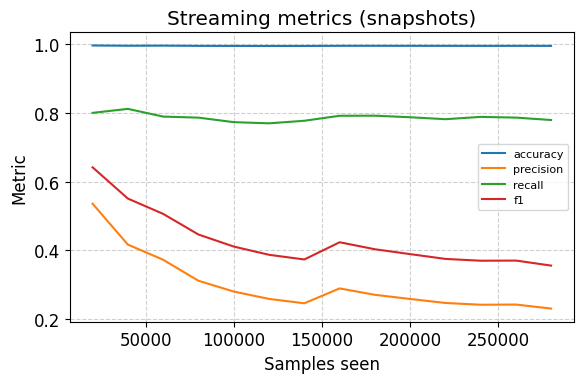

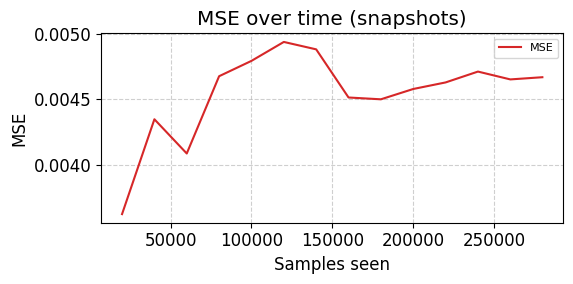


--- Preview (first 2000 predictions) ---


,y_true,y_pred,prob_pred
0,0,0,6.000000e-04
1,0,0,5.998800e-04
2,0,0,5.997601e-04
3,0,0,4.600203e-18
4,0,0,5.996402e-04
5,0,0,1.370067e-02
6,0,0,2.608733e-16
7,0,0,5.995204e-04
8,0,0,8.494170e-13
9,0,0,1.650069e-02



Value counts (preview):
y_true  y_pred  prob_pred   
0       0       1.452593e-31    1
                8.998660e-31    1
                1.090222e-30    1
                3.025038e-30    1
                3.402927e-30    1
                8.733802e-30    1
                2.772278e-29    1
                4.329548e-29    1
                4.382380e-29    1
                4.498720e-29    1
Name: count, dtype: int64


In [11]:
# 10_plots_preview.py - smaller plots and clean preview output

if len(metrics_records) > 0:
    mdf = pd.DataFrame(metrics_records)

    # Smaller plot size for metric trends
    plt.figure(figsize=(6, 4))
    plt.plot(mdf['samples'], mdf['accuracy'], label='accuracy')
    plt.plot(mdf['samples'], mdf['precision'], label='precision')
    plt.plot(mdf['samples'], mdf['recall'], label='recall')
    plt.plot(mdf['samples'], mdf['f1'], label='f1')
    plt.xlabel('Samples seen')
    plt.ylabel('Metric')
    plt.title('Streaming metrics (snapshots)')
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Smaller plot for MSE
    plt.figure(figsize=(6, 3))
    plt.plot(mdf['samples'], mdf['mse'], label='MSE', color='tab:red')
    plt.xlabel('Samples seen')
    plt.ylabel('MSE')
    plt.title('MSE over time (snapshots)')
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Preview of early outcomes (first up to 2000 predictions)
rows_preview = min(2000, len(y_true_list))
preview_df = pd.DataFrame({
    'y_true': y_true_list[:rows_preview],
    'y_pred': y_pred_list[:rows_preview],
    'prob_pred': prob_pred_list[:rows_preview]
})

print(f"\n--- Preview (first {rows_preview} predictions) ---")
display(preview_df.head(20))  # show fewer rows for smaller display
print("\nValue counts (preview):")
print(preview_df.value_counts().head(10))


Data alignment check:
Length of X_all: 284807
Length of y_true_list: 279807
Length of y_pred_list: 279807
Initial warmup samples: 5000
✅ Successfully created prediction dataframe with 279807 rows

📊 FRAUD vs NON-FRAUD DETECTION VISUALIZATION
Fraud transactions detected: 1,656
Normal transactions detected: 278,151

📊 FRAUD vs NON-FRAUD DETECTION VISUALIZATION
Fraud transactions detected: 1,656
Normal transactions detected: 278,151


C:\Users\Admin\AppData\Local\Temp\ipykernel_9972\1979918223.py:348: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
c:\Users\Admin\Desktop\Fraud Detection\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\Desktop\Fraud Detection\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


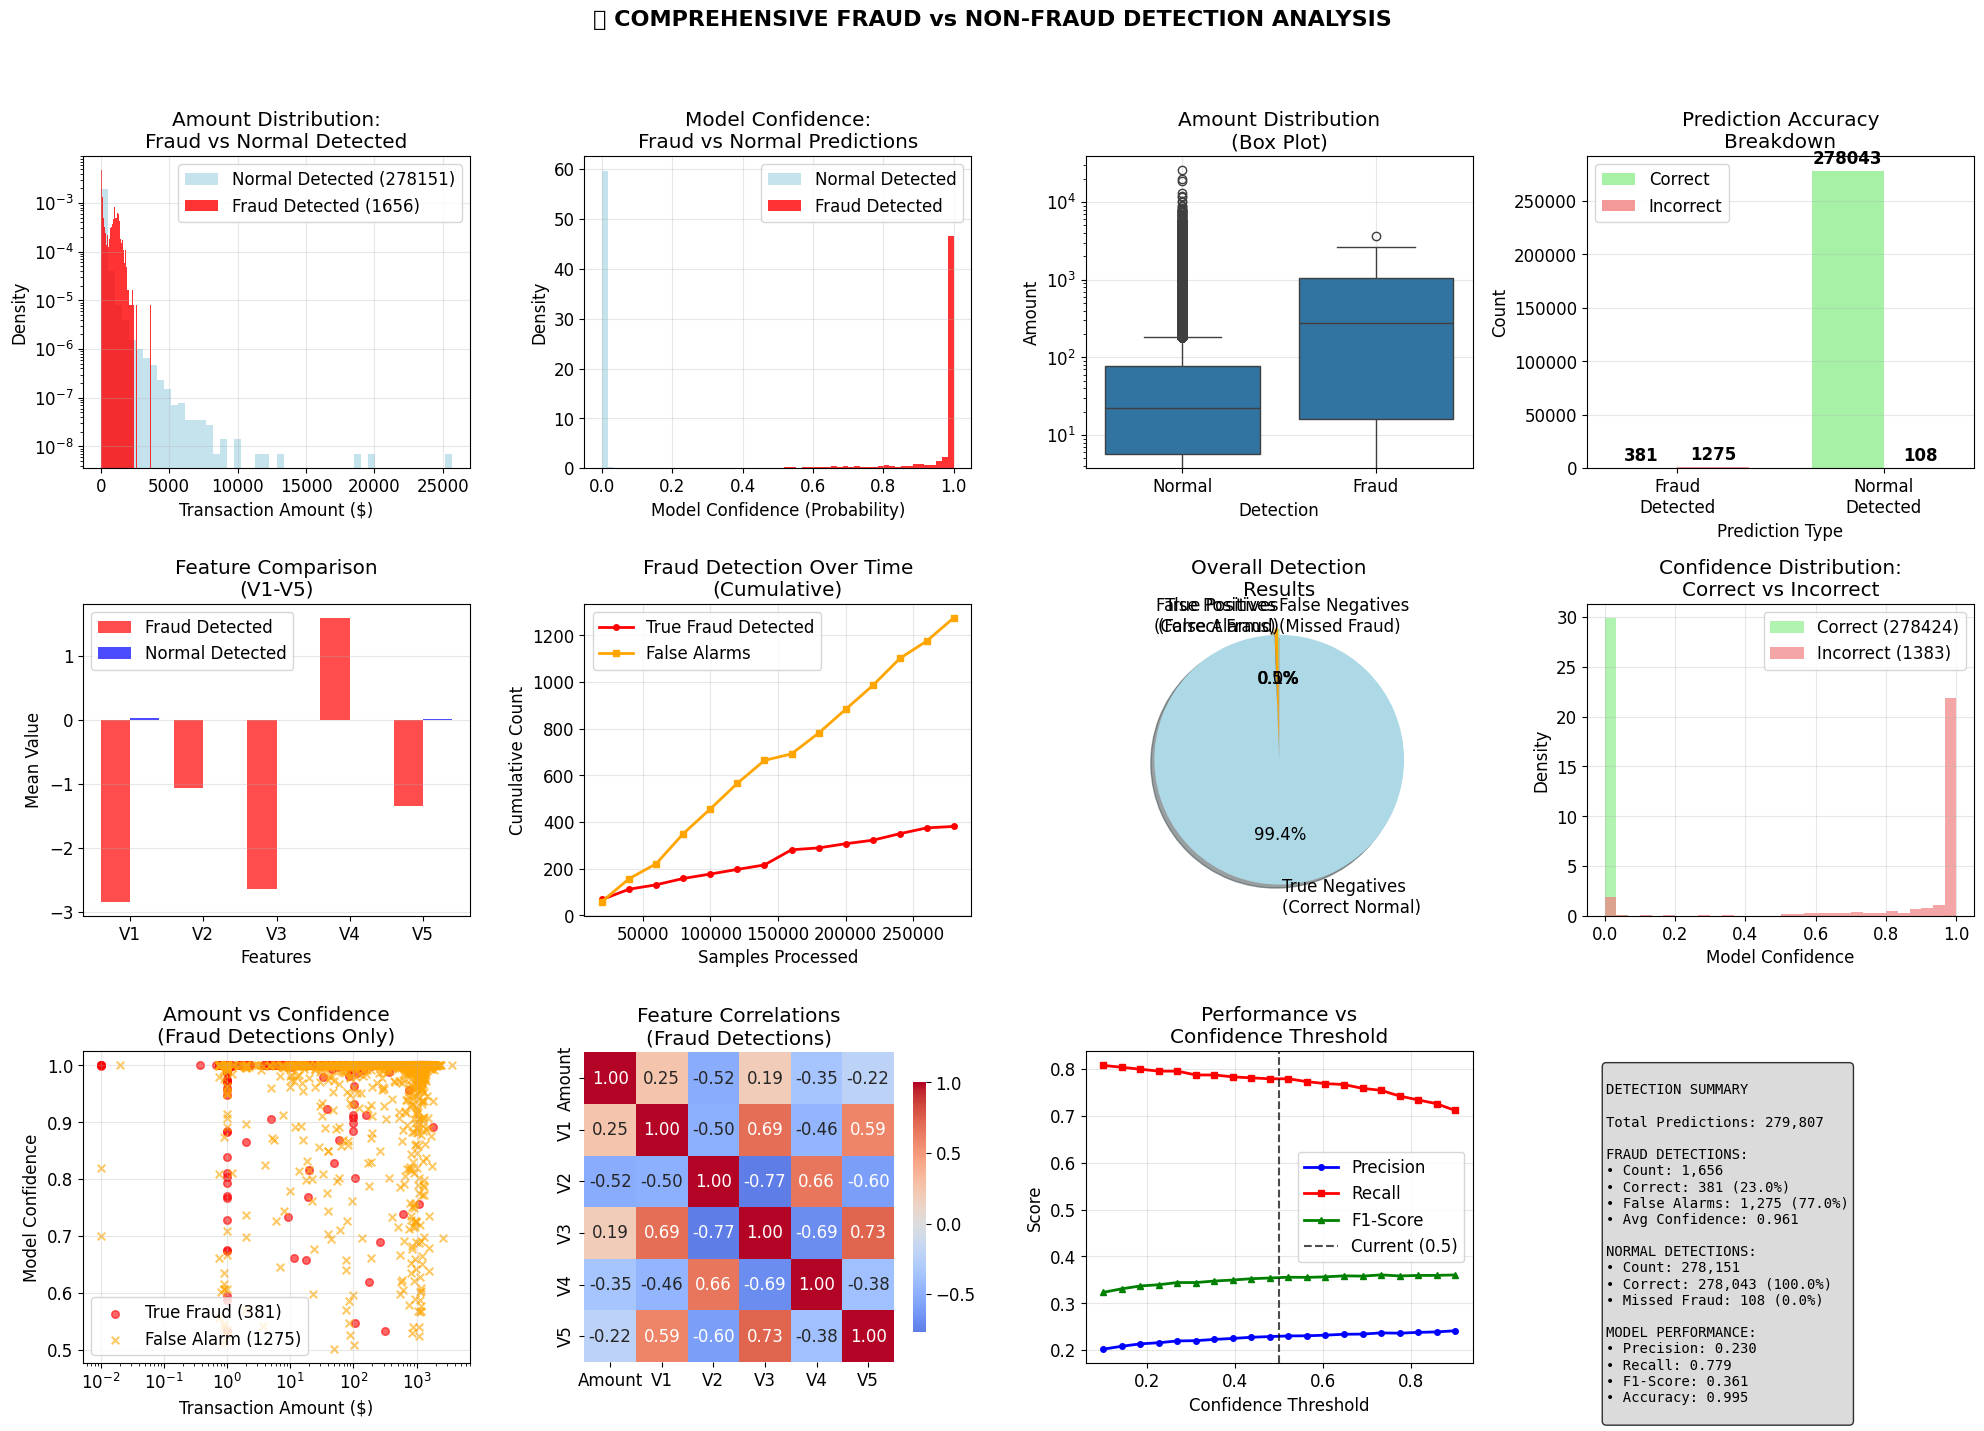


🎯 DETAILED FRAUD vs NON-FRAUD BREAKDOWN

💰 TRANSACTION AMOUNTS:
Fraud Detected - Mean: $558.22, Median: $281.00
Normal Detected - Mean: $85.99, Median: $22.00

🎲 MODEL CONFIDENCE:
Fraud Predictions - Mean: 0.9606, Min: 0.5011, Max: 1.0000
Normal Predictions - Mean: 0.0012, Min: 0.0000, Max: 0.4988

✅ ACCURACY BY PREDICTION TYPE:
Fraud Detection Accuracy: 23.01% (381/1656)
Normal Detection Accuracy: 99.96% (278043/278151)

🔥 HIGH-CONFIDENCE DETECTIONS:
High-confidence fraud (≥80%): 1522 transactions
High-confidence normal (≤20%): 277989 transactions



In [12]:
# 11_fraud_detection_plots.py - purpose: visualize fraud vs non-fraud detections

import seaborn as sns

# Create prediction dataframe for visualization
# Note: y_true_list and y_pred_list only contain data from streaming loop (after warmup)
# So we need to use the corresponding subset of X_all

print(f"Data alignment check:")
print(f"Length of X_all: {len(X_all)}")
print(f"Length of y_true_list: {len(y_true_list)}")
print(f"Length of y_pred_list: {len(y_pred_list)}")
print(f"Initial warmup samples: {initial_warmup}")

# Get the corresponding features for the streaming data (after warmup)
X_streaming = X_all.iloc[initial_warmup:initial_warmup + len(y_true_list)].copy()

# Create prediction dataframe with aligned data
pred_df = X_streaming.copy()
pred_df['y_true'] = y_true_list
pred_df['y_pred'] = y_pred_list
pred_df['prob_pred'] = prob_pred_list

print(f"✅ Successfully created prediction dataframe with {len(pred_df)} rows")

# Separate fraud and non-fraud predictions
fraud_detected = pred_df[pred_df['y_pred'] == 1]
normal_detected = pred_df[pred_df['y_pred'] == 0]

print(f"\n📊 FRAUD vs NON-FRAUD DETECTION VISUALIZATION")
print(f"Fraud transactions detected: {len(fraud_detected):,}")
print(f"Normal transactions detected: {len(normal_detected):,}")

# Create comprehensive visualization
plt.figure(figsize=(20, 15))

# 1. Transaction Amount Distribution - Fraud vs Normal Detected
plt.subplot(3, 4, 1)
if 'Amount' in pred_df.columns:
    plt.hist(normal_detected['Amount'], bins=50, alpha=0.7, label=f'Normal Detected ({len(normal_detected)})', 
             color='lightblue', density=True)
    plt.hist(fraud_detected['Amount'], bins=50, alpha=0.8, label=f'Fraud Detected ({len(fraud_detected)})', 
             color='red', density=True)
    plt.xlabel('Transaction Amount ($)')
    plt.ylabel('Density')
    plt.title('Amount Distribution:\nFraud vs Normal Detected')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

# 2. Prediction Confidence Comparison
plt.subplot(3, 4, 2)
plt.hist(normal_detected['prob_pred'], bins=30, alpha=0.7, label='Normal Detected', 
         color='lightblue', density=True)
plt.hist(fraud_detected['prob_pred'], bins=30, alpha=0.8, label='Fraud Detected', 
         color='red', density=True)
plt.xlabel('Model Confidence (Probability)')
plt.ylabel('Density')
plt.title('Model Confidence:\nFraud vs Normal Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Box plot of Amount by prediction type
plt.subplot(3, 4, 3)
if 'Amount' in pred_df.columns and len(fraud_detected) > 0 and len(normal_detected) > 0:
    # Create data for box plot
    amounts_data = []
    labels_data = []
    
    amounts_data.extend(normal_detected['Amount'].tolist())
    labels_data.extend(['Normal'] * len(normal_detected))
    
    amounts_data.extend(fraud_detected['Amount'].tolist())
    labels_data.extend(['Fraud'] * len(fraud_detected))
    
    box_df = pd.DataFrame({'Amount': amounts_data, 'Detection': labels_data})
    sns.boxplot(data=box_df, x='Detection', y='Amount')
    plt.title('Amount Distribution\n(Box Plot)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Insufficient data\nfor box plot', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Amount Distribution\n(Box Plot)')

# 4. Prediction accuracy breakdown
plt.subplot(3, 4, 4)
# Calculate accuracy for each prediction type
fraud_correct = len(fraud_detected[fraud_detected['y_true'] == 1]) if len(fraud_detected) > 0 else 0
fraud_incorrect = len(fraud_detected[fraud_detected['y_true'] == 0]) if len(fraud_detected) > 0 else 0
normal_correct = len(normal_detected[normal_detected['y_true'] == 0]) if len(normal_detected) > 0 else 0
normal_incorrect = len(normal_detected[normal_detected['y_true'] == 1]) if len(normal_detected) > 0 else 0

categories = ['Fraud\nDetected', 'Normal\nDetected']
correct = [fraud_correct, normal_correct]
incorrect = [fraud_incorrect, normal_incorrect]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, correct, width, label='Correct', color='lightgreen', alpha=0.8)
plt.bar(x + width/2, incorrect, width, label='Incorrect', color='lightcoral', alpha=0.8)

plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.title('Prediction Accuracy\nBreakdown')
plt.xticks(x, categories)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (c, ic) in enumerate(zip(correct, incorrect)):
    if max(correct + incorrect) > 0:
        plt.text(i - width/2, c + max(correct + incorrect) * 0.01, str(c), 
                 ha='center', va='bottom', fontweight='bold')
        plt.text(i + width/2, ic + max(correct + incorrect) * 0.01, str(ic), 
                 ha='center', va='bottom', fontweight='bold')

# 5. Feature analysis for detected frauds (V1-V5)
plt.subplot(3, 4, 5)
if len(fraud_detected) > 0 and len(normal_detected) > 0:
    v_features = ['V1', 'V2', 'V3', 'V4', 'V5']
    available_features = [f for f in v_features if f in fraud_detected.columns]
    
    if available_features:
        fraud_means = fraud_detected[available_features].mean()
        normal_means = normal_detected[available_features].mean()
        
        x_pos = np.arange(len(available_features))
        plt.bar(x_pos - 0.2, fraud_means, 0.4, label='Fraud Detected', color='red', alpha=0.7)
        plt.bar(x_pos + 0.2, normal_means, 0.4, label='Normal Detected', color='blue', alpha=0.7)
        
        plt.xlabel('Features')
        plt.ylabel('Mean Value')
        plt.title('Feature Comparison\n(V1-V5)')
        plt.xticks(x_pos, available_features)
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
    else:
        plt.text(0.5, 0.5, 'No V features\navailable', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Comparison\n(V1-V5)')
else:
    plt.text(0.5, 0.5, 'Insufficient fraud\ndetections', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Comparison\n(V1-V5)')

# 6. Time series of detections (if we have enough data points)
plt.subplot(3, 4, 6)
if len(metrics_records) > 0:
    mdf = pd.DataFrame(metrics_records)
    
    # Calculate cumulative fraud detections over time
    cumulative_samples = mdf['samples'].tolist()
    cumulative_tp = mdf['tp'].tolist()
    cumulative_fp = mdf['fp'].tolist()
    
    plt.plot(cumulative_samples, cumulative_tp, 'r-', linewidth=2, 
             label=f'True Fraud Detected', marker='o', markersize=4)
    plt.plot(cumulative_samples, cumulative_fp, 'orange', linewidth=2, 
             label=f'False Alarms', marker='s', markersize=4)
    
    plt.xlabel('Samples Processed')
    plt.ylabel('Cumulative Count')
    plt.title('Fraud Detection Over Time\n(Cumulative)')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No time series\ndata available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Fraud Detection Over Time\n(Cumulative)')

# 7. Pie chart of detection results
plt.subplot(3, 4, 7)
true_positives = len(fraud_detected[fraud_detected['y_true'] == 1]) if len(fraud_detected) > 0 else 0
false_positives = len(fraud_detected[fraud_detected['y_true'] == 0]) if len(fraud_detected) > 0 else 0
true_negatives = len(normal_detected[normal_detected['y_true'] == 0]) if len(normal_detected) > 0 else 0
false_negatives = len(normal_detected[normal_detected['y_true'] == 1]) if len(normal_detected) > 0 else 0

labels = ['True Positives\n(Correct Fraud)', 'False Positives\n(False Alarms)', 
          'True Negatives\n(Correct Normal)', 'False Negatives\n(Missed Fraud)']
sizes = [true_positives, false_positives, true_negatives, false_negatives]
colors = ['lightgreen', 'orange', 'lightblue', 'lightcoral']
explode = (0.05, 0.05, 0, 0.05)  # explode fraud-related slices

# Only create pie chart if we have data
if sum(sizes) > 0:
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.title('Overall Detection\nResults')
else:
    plt.text(0.5, 0.5, 'No prediction\ndata available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Overall Detection\nResults')

# 8. Detection confidence by correctness
plt.subplot(3, 4, 8)
if len(pred_df) > 0:
    # Separate correct and incorrect predictions
    correct_preds = pred_df[pred_df['y_true'] == pred_df['y_pred']]
    incorrect_preds = pred_df[pred_df['y_true'] != pred_df['y_pred']]

    if len(correct_preds) > 0 or len(incorrect_preds) > 0:
        plt.hist(correct_preds['prob_pred'], bins=30, alpha=0.7, label=f'Correct ({len(correct_preds)})', 
                 color='lightgreen', density=True)
        plt.hist(incorrect_preds['prob_pred'], bins=30, alpha=0.7, label=f'Incorrect ({len(incorrect_preds)})', 
                 color='lightcoral', density=True)
        plt.xlabel('Model Confidence')
        plt.ylabel('Density')
        plt.title('Confidence Distribution:\nCorrect vs Incorrect')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No prediction\ndata available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Confidence Distribution:\nCorrect vs Incorrect')
else:
    plt.text(0.5, 0.5, 'No prediction\ndata available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Confidence Distribution:\nCorrect vs Incorrect')

# 9. Scatter plot: Amount vs Confidence for fraud detections
plt.subplot(3, 4, 9)
if 'Amount' in pred_df.columns and len(fraud_detected) > 0:
    # True fraud detections
    true_fraud = fraud_detected[fraud_detected['y_true'] == 1]
    false_fraud = fraud_detected[fraud_detected['y_true'] == 0]
    
    if len(true_fraud) > 0:
        plt.scatter(true_fraud['Amount'], true_fraud['prob_pred'], 
                   alpha=0.6, c='red', s=30, label=f'True Fraud ({len(true_fraud)})', marker='o')
    if len(false_fraud) > 0:
        plt.scatter(false_fraud['Amount'], false_fraud['prob_pred'], 
                   alpha=0.6, c='orange', s=30, label=f'False Alarm ({len(false_fraud)})', marker='x')
    
    plt.xlabel('Transaction Amount ($)')
    plt.ylabel('Model Confidence')
    plt.title('Amount vs Confidence\n(Fraud Detections Only)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if len(fraud_detected) > 0:
        plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No fraud detections\nto analyze', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Amount vs Confidence\n(Fraud Detections Only)')

# 10. Feature correlation heatmap for fraud detections
plt.subplot(3, 4, 10)
if len(fraud_detected) > 5:  # Need enough samples for correlation
    feature_subset = ['Amount'] + [f'V{i}' for i in range(1, 6) if f'V{i}' in fraud_detected.columns]
    available_features = [f for f in feature_subset if f in fraud_detected.columns]
    
    if len(available_features) > 1:
        corr_matrix = fraud_detected[available_features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Feature Correlations\n(Fraud Detections)')
    else:
        plt.text(0.5, 0.5, 'Insufficient features\nfor correlation', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Correlations')
else:
    plt.text(0.5, 0.5, f'Need >5 fraud detections\n(have {len(fraud_detected)})', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Correlations\n(Fraud Detections)')

# 11. Detection performance by confidence threshold
plt.subplot(3, 4, 11)
if len(y_true_list) > 0 and len(prob_pred_list) > 0:
    thresholds = np.linspace(0.1, 0.9, 20)
    precisions, recalls, f1_scores = [], [], []

    for thresh in thresholds:
        y_pred_thresh = (np.array(prob_pred_list) >= thresh).astype(int)
        if y_pred_thresh.sum() > 0:
            prec = precision_score(y_true_list, y_pred_thresh, zero_division=0)
            rec = recall_score(y_true_list, y_pred_thresh, zero_division=0)
            f1 = f1_score(y_true_list, y_pred_thresh, zero_division=0)
        else:
            prec, rec, f1 = 0, 0, 0
        
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

    plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2, marker='o', markersize=4)
    plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2, marker='s', markersize=4)
    plt.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2, marker='^', markersize=4)
    plt.axvline(x=threshold, color='black', linestyle='--', alpha=0.7, label=f'Current ({threshold})')

    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.title('Performance vs\nConfidence Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No prediction\ndata available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Performance vs\nConfidence Threshold')

# 12. Summary statistics table
plt.subplot(3, 4, 12)
plt.axis('off')

# Create summary text
if len(pred_df) > 0 and len(fraud_detected) >= 0 and len(normal_detected) >= 0:
    precision_val = true_positives/(true_positives+false_positives) if (true_positives+false_positives) > 0 else 0
    recall_val = true_positives/(true_positives+false_negatives) if (true_positives+false_negatives) > 0 else 0
    accuracy_val = (true_positives+true_negatives)/len(pred_df) if len(pred_df) > 0 else 0
    
    # Calculate percentages safely
    fraud_correct_pct = (true_positives/len(fraud_detected)*100) if len(fraud_detected) > 0 else 0.0
    fraud_incorrect_pct = (false_positives/len(fraud_detected)*100) if len(fraud_detected) > 0 else 0.0
    normal_correct_pct = (true_negatives/len(normal_detected)*100) if len(normal_detected) > 0 else 0.0
    normal_incorrect_pct = (false_negatives/len(normal_detected)*100) if len(normal_detected) > 0 else 0.0
    avg_fraud_confidence = fraud_detected['prob_pred'].mean() if len(fraud_detected) > 0 else 0.0
    f1_val = f1 if 'f1' in locals() else 0.0
    
    summary_text = f"""
DETECTION SUMMARY

Total Predictions: {len(pred_df):,}

FRAUD DETECTIONS:
• Count: {len(fraud_detected):,}
• Correct: {true_positives:,} ({fraud_correct_pct:.1f}%)
• False Alarms: {false_positives:,} ({fraud_incorrect_pct:.1f}%)
• Avg Confidence: {avg_fraud_confidence:.3f}

NORMAL DETECTIONS:
• Count: {len(normal_detected):,}
• Correct: {true_negatives:,} ({normal_correct_pct:.1f}%)
• Missed Fraud: {false_negatives:,} ({normal_incorrect_pct:.1f}%)

MODEL PERFORMANCE:
• Precision: {precision_val:.3f}
• Recall: {recall_val:.3f}
• F1-Score: {f1_val:.3f}
• Accuracy: {accuracy_val:.3f}
"""
else:
    summary_text = """
DETECTION SUMMARY

No prediction data available.
Please run the streaming loop first.
"""

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontfamily='monospace', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('🔍 COMPREHENSIVE FRAUD vs NON-FRAUD DETECTION ANALYSIS', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print detailed breakdown
if len(pred_df) > 0:
    print(f"\n" + "="*80)
    print(f"🎯 DETAILED FRAUD vs NON-FRAUD BREAKDOWN")
    print(f"="*80)

    if 'Amount' in pred_df.columns:
        print(f"\n💰 TRANSACTION AMOUNTS:")
        if len(fraud_detected) > 0:
            print(f"Fraud Detected - Mean: ${fraud_detected['Amount'].mean():.2f}, Median: ${fraud_detected['Amount'].median():.2f}")
        else:
            print(f"Fraud Detected - No fraud transactions detected")
        if len(normal_detected) > 0:
            print(f"Normal Detected - Mean: ${normal_detected['Amount'].mean():.2f}, Median: ${normal_detected['Amount'].median():.2f}")
        else:
            print(f"Normal Detected - No normal transactions detected")

    print(f"\n🎲 MODEL CONFIDENCE:")
    if len(fraud_detected) > 0:
        print(f"Fraud Predictions - Mean: {fraud_detected['prob_pred'].mean():.4f}, Min: {fraud_detected['prob_pred'].min():.4f}, Max: {fraud_detected['prob_pred'].max():.4f}")
    else:
        print(f"Fraud Predictions - No fraud predictions available")
    if len(normal_detected) > 0:
        print(f"Normal Predictions - Mean: {normal_detected['prob_pred'].mean():.4f}, Min: {normal_detected['prob_pred'].min():.4f}, Max: {normal_detected['prob_pred'].max():.4f}")
    else:
        print(f"Normal Predictions - No normal predictions available")

    print(f"\n✅ ACCURACY BY PREDICTION TYPE:")
    if len(fraud_detected) > 0:
        print(f"Fraud Detection Accuracy: {true_positives/len(fraud_detected)*100:.2f}% ({true_positives}/{len(fraud_detected)})")
    else:
        print(f"Fraud Detection Accuracy: N/A (no fraud predictions)")
    if len(normal_detected) > 0:
        print(f"Normal Detection Accuracy: {true_negatives/len(normal_detected)*100:.2f}% ({true_negatives}/{len(normal_detected)})")
    else:
        print(f"Normal Detection Accuracy: N/A (no normal predictions)")

    print(f"\n🔥 HIGH-CONFIDENCE DETECTIONS:")
    if len(fraud_detected) > 0:
        high_conf_fraud = fraud_detected[fraud_detected['prob_pred'] >= 0.8]
        print(f"High-confidence fraud (≥80%): {len(high_conf_fraud)} transactions")
    else:
        print(f"High-confidence fraud (≥80%): 0 transactions")
    if len(normal_detected) > 0:
        high_conf_normal = normal_detected[normal_detected['prob_pred'] <= 0.2]
        print(f"High-confidence normal (≤20%): {len(high_conf_normal)} transactions")
    else:
        print(f"High-confidence normal (≤20%): 0 transactions")

    print(f"\n" + "="*80)
else:
    print(f"\n" + "="*80)
    print(f"⚠️  NO PREDICTION DATA AVAILABLE")
    print(f"="*80)
    print(f"Please run the streaming loop (cell 9) first to generate predictions.")
    print(f"="*80)